<a href="https://colab.research.google.com/github/ShivamG0897/Predictive-Maintenance/blob/main/Copy_of_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#we used google colab for this task and all the data files uploaded from my google drive
from google.colab import drive
drive.mount('/content/drive')

# Accessing GPU
# From Runtime in tools bar mentioned above < change runtime to gpu and verify using below code
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is NOT AVAILABLE


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('ggplot')

In [ ]:
df_failure = pd.read_csv('/content/drive/MyDrive/data files/PdM_failures.csv')
df_errors = pd.read_csv('/content/drive/MyDrive/data files/PdM_errors.csv')
df_machines = pd.read_csv('/content/drive/MyDrive/data files/PdM_machines.csv')
df_maint = pd.read_csv('/content/drive/MyDrive/data files/PdM_maint.csv')
df_telemetry = pd.read_csv('/content/drive/MyDrive/data files/PdM_telemetry.csv')

In [ ]:
def get_data_info(df):
    print("-"*50)
    print("Number of rows: ",df.shape[0])
    print("Number of Columns: ",df.shape[1])
    print("-"*50)
    print("Column-Wise missing values: ")
    print(df.isna().sum())
    print("-"*50)
    print("Count of mentioned data types")
    print(df.dtypes.value_counts())
    print("-"*50)
    print("Duplicate instances:", df.duplicated().sum())


def get_float_type_columns(df):
    return df.columns[df.dtypes == "float64"]

In [ ]:
# Failures
df_failure['datetime'] = pd.to_datetime(df_failure['datetime'], format="%Y-%m-%d %H:%M:%S")
df_failure['failure'] = df_failure['failure'].astype('category')
# Errors
df_errors['datetime'] = pd.to_datetime(df_errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
df_errors['errorID'] = df_errors['errorID'].astype('category')
# Maintenance
df_maint['datetime'] = pd.to_datetime(df_maint['datetime'], format='%Y-%m-%d %H:%M:%S')
df_maint['comp'] = df_maint['comp'].astype('category')
# Machines Meta
df_machines['model'] = df_machines['model'].astype('category')
# Telemetry
df_telemetry['datetime'] = pd.to_datetime(df_telemetry['datetime'])
df_telemetry.set_index('datetime', inplace=True)

In [ ]:
# Calculate mean values for telemetry features
# https://www.youtube.com/watch?v=l4dvMiSDBzs # how resample works
# https://www.youtube.com/watch?v=KuT2n1w0Ixc&list=LL&index=1 ; explains pivot shift is good for reliability
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(df_telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(df_telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_mean_3h.head(1)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502


In [ ]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(df_telemetry.pivot_table(index='datetime', columns='machineID', values=col)
                    .rolling(window=24)
                    .mean()
                    .resample('3H', closed='left', label='right')
                    .first()
                    .unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# Calculate rolling standard deviations
temp = []
for col in fields:
    temp.append(pd.pivot_table(df_telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col)
                .rolling(window=24)
                .std()
                .resample('3H', closed='left', label='right')
                .first()
                .unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(1)

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.38516


In [ ]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.keys()

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h'],
      dtype='object')

-----------
***Lags from Maintenance - get the difference of days for each component when it was last maintained***

In [ ]:
comp_rep = pd.get_dummies(df_maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()
comp_rep = pd.get_dummies(df_maint.set_index('datetime')).reset_index() # create a column for each maintenance type
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
df_telemetry.reset_index(inplace = True)
comp_rep = df_telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']

    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]


# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')

comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


-------
***Lags from errors***

In [ ]:
error_count = pd.get_dummies(df_errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count = df_telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)

# compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours
temp = []
fields = ['error%d' % i for i in range(1, 6)] # creates strings like "error1"..."error5".

for col in fields:
    temp.append(
        pd.pivot_table(error_count,
                       index='datetime',
                       columns='machineID',
                       values=col)
        .rolling(window=24)
        .sum()
        .resample('3H', closed='left', label='right')
        .first()
        .unstack()
    )

error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()


,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


----
***Merging***

In [ ]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(df_machines, on=['machineID'], how='left')

display(final_feat.head(3))


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18


In [ ]:
# Failure type 'none' couldn't be directly added to the column.
labeled_features = final_feat.merge(df_failure, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7)
labeled_features = labeled_features.fillna(method='ffill', limit=7)
labeled_features['failure'] = labeled_features['failure'].cat.add_categories(['none'])

# Fill missing values with the 'missing' category
labeled_features['failure'].fillna('none', inplace=True)

In [ ]:
labeled_features.isna().sum().sum()

0

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    # train and predict using the model, storing results for later
    my_model = GradientBoostingClassifier(random_state=42)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model) #runtime on T4 GPU is 43 mins

<ipython-input-16-786412278f69>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
<ipython-input-16-786412278f69>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, ConfusionMatrixDisplay

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []

    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])

    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])

    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)

    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])

    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])

    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels

    return output_df

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

Text(0, 0.5, 'Count')

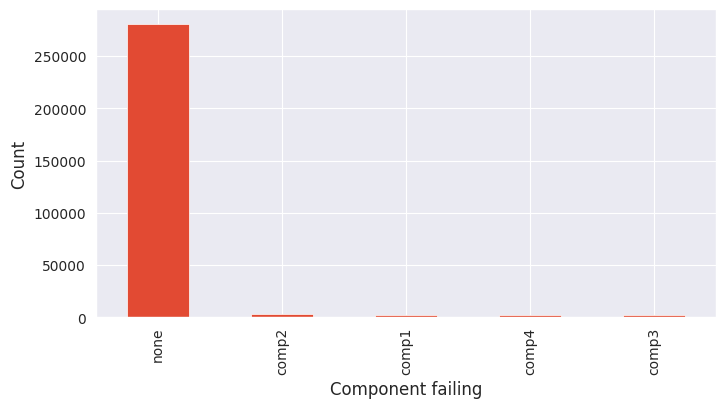

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

In [ ]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[118119    115     59     19     12]
 [    54    872      3      5      7]
 [    48      5   1525      9      3]
 [    22      4      1    716      2]
 [    16      1      7      1    994]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[94257    74    37    12    12]
 [   49   682     3     1     2]
 [   42     5  1245    10     2]
 [   14     0     0   566     1]
 [   14     1     2     1   781]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[71125    59    20    15    12]
 [   39   515     3     0     1]
 [   37     4   998     0     0]
 [   16     2     0   394     2]
 [    9     1     3     1   553]]


,none,comp1,comp2,comp3,comp4
accuracy,0.996795,0.996795,0.996795,0.996795,0.996795
precision,0.998816,0.874624,0.956113,0.954667,0.976424
recall,0.998267,0.926674,0.959119,0.961074,0.975466
F1,0.998542,0.899897,0.957614,0.957860,0.975945
macro precision,0.952129,0.952129,0.952129,0.952129,0.952129
macro recall,0.964120,0.964120,0.964120,0.964120,0.964120
macro F1,0.957971,0.957971,0.957971,0.957971,0.957971
average accuracy,0.998718,0.998718,0.998718,0.998718,0.998718
micro-averaged precision/recall/F1,0.996795,0.996795,0.996795,0.996795,0.996795
majority class accuracy,0.964973,0.000000,0.000000,0.000000,0.000000


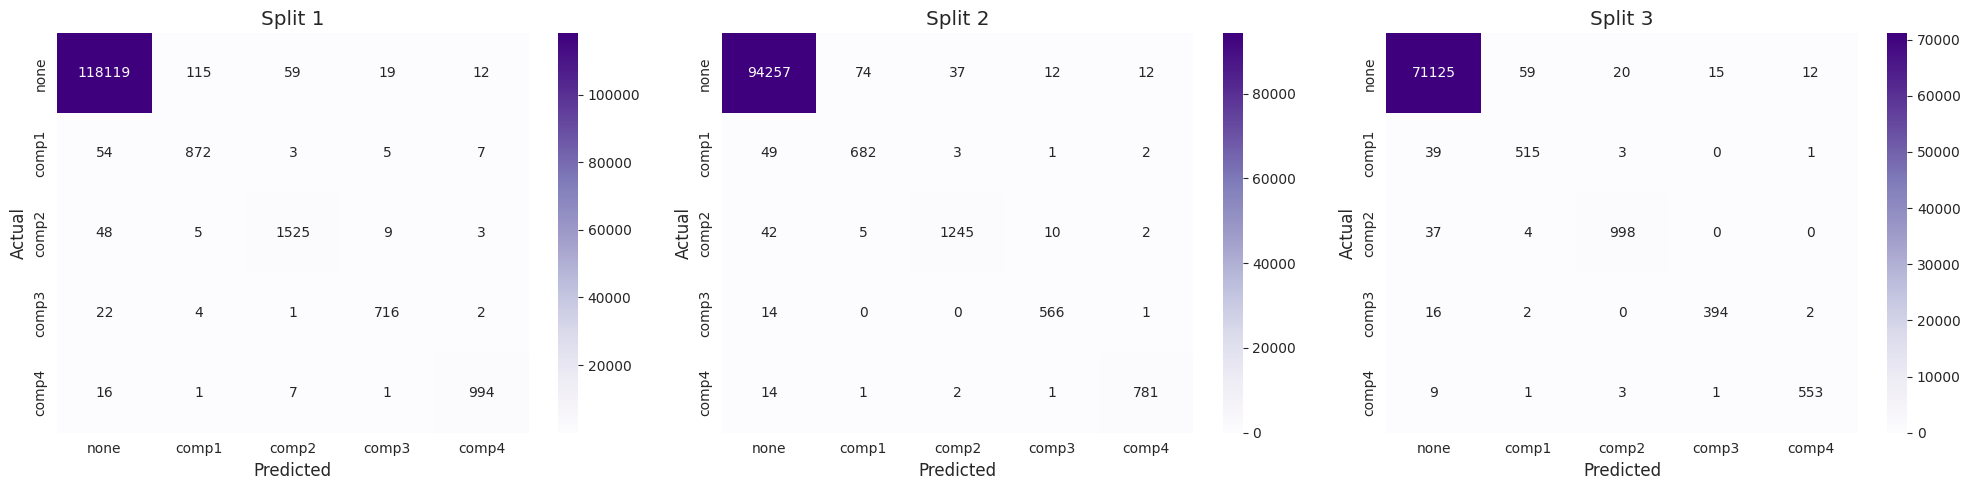

In [ ]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

for i, (test_result, ax) in enumerate(zip(test_results, axes)):
    actual = test_result['failure']
    predicted = test_result['predicted_failure']
    cm = confusion_matrix(actual, predicted, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Purples', ax=ax)
    ax.set_title(f'Split {i+1}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()



---------------
***Light Gradient Boosting Classifier***

In [ ]:
import lightgbm as lgb

# make test and training splits
threshold_dates = [
    [pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
    [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
    [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]
]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    # train and predict using the model, storing results for later
    my_model = lgb.LGBMClassifier(random_state=42)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model) # runtime 37 seconds using t4 GPU (all splits included)


<ipython-input-18-bd15b693a4d4>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
<ipython-input-18-bd15b693a4d4>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5143
[LightGBM] [Info] Number of data points in the train set: 167922, number of used features: 30
[LightGBM] [Info] Start training from score -4.611275
[LightGBM] [Info] Start training from score -4.403710
[LightGBM] [Info] Start training from score -5.037322
[LightGBM] [Info] Start training from score -4.755390
[LightGBM] [Info] Start training from score -0.037979


<ipython-input-18-bd15b693a4d4>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
<ipython-input-18-bd15b693a4d4>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5143
[LightGBM] [Info] Number of data points in the train set: 192728, number of used features: 30
[LightGBM] [Info] Start training from score -4.633205
[LightGBM] [Info] Start training from score -4.414125
[LightGBM] [Info] Start training from score -5.047783
[LightGBM] [Info] Start training from score -4.747259
[LightGBM] [Info] Start training from score -0.037627


<ipython-input-18-bd15b693a4d4>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
<ipython-input-18-bd15b693a4d4>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5143
[LightGBM] [Info] Number of data points in the train set: 216732, number of used features: 30
[LightGBM] [Info] Start training from score -4.662286
[LightGBM] [Info] Start training from score -4.420845
[LightGBM] [Info] Start training from score -5.032239
[LightGBM] [Info] Start training from score -4.737861
[LightGBM] [Info] Start training from score -0.037443


Text(0, 0.5, 'Importance')

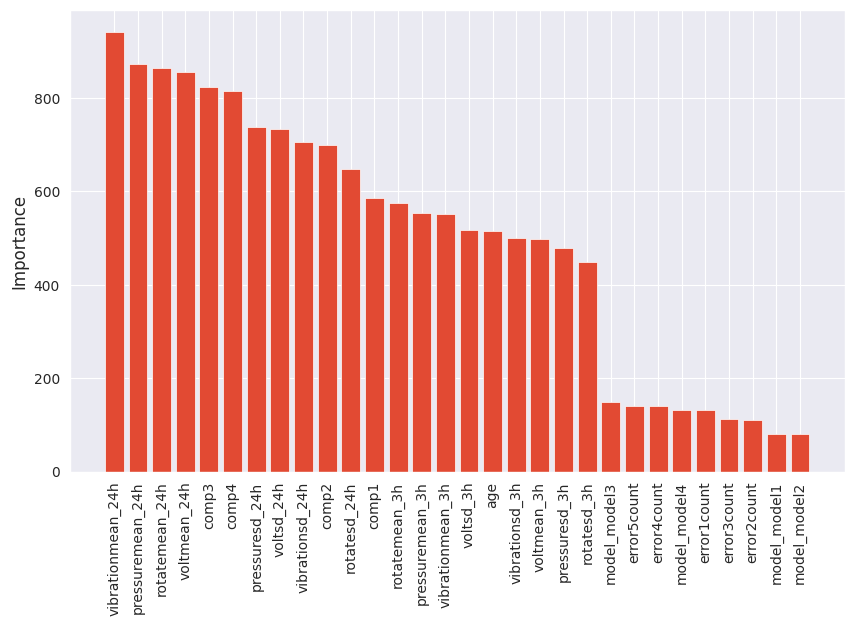

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

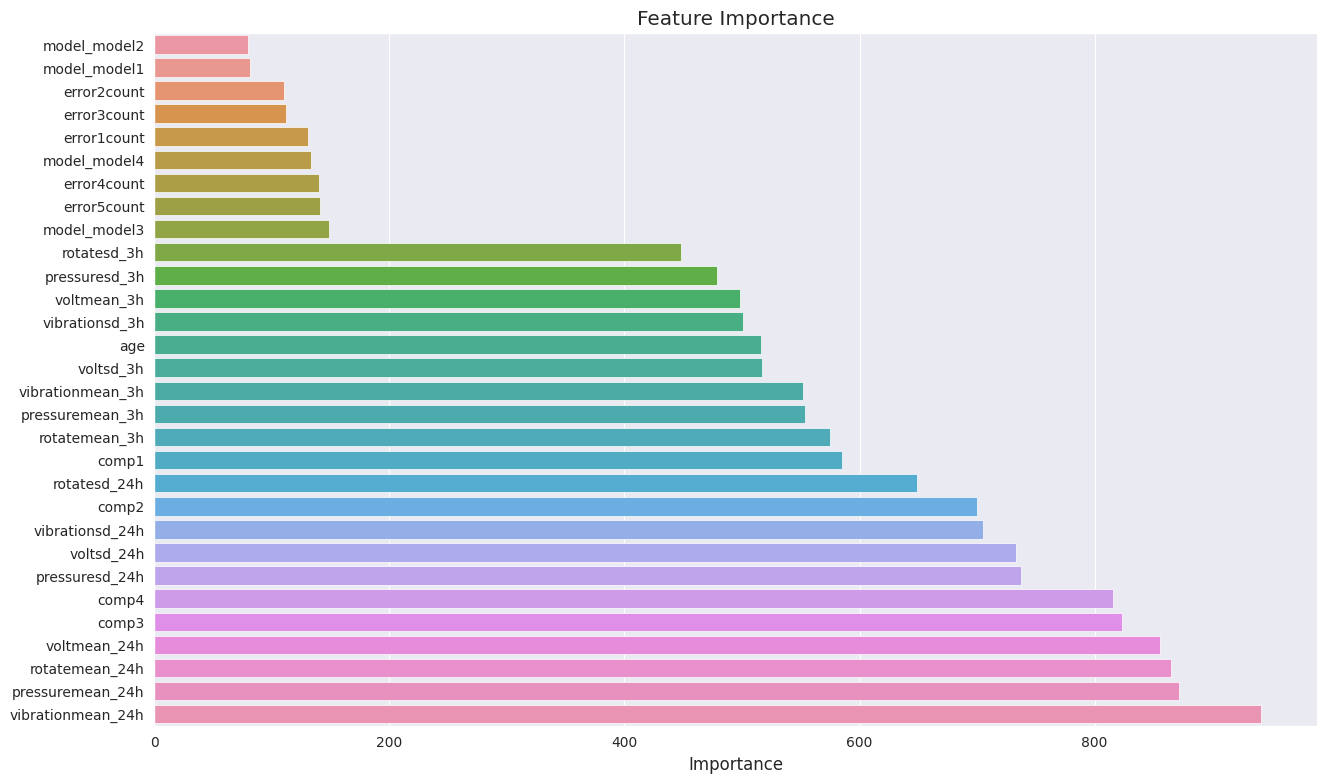

In [ ]:
# assuming models[0] is your trained model
importances = models[0].feature_importances_

# sort the features by importance
sorted_idx = np.argsort(importances)

# plot feature importance
plt.figure(figsize=(15, 9))
sns.barplot(x=importances[sorted_idx][:40], y=test_X.columns[sorted_idx][:40])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()



In [ ]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[118069    110     88     33     24]
 [    72    857      6      3      3]
 [    62      4   1509      8      7]
 [    32      0      2    710      1]
 [    36      3      2      0    978]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[94244    69    54     9    16]
 [   77   655     5     0     0]
 [   61     5  1227     7     4]
 [   22     1     2   555     1]
 [   26     4     1     0   768]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[71130    52    30     5    14]
 [   58   498     0     0     2]
 [   59     7   971     0     2]
 [   17     1     0   395     1]
 [   20     1     2     0   544]]


,none,comp1,comp2,comp3,comp4
accuracy,0.995955,0.995955,0.995955,0.995955,0.995955
precision,0.998292,0.879877,0.939017,0.941645,0.965449
recall,0.997845,0.910733,0.949057,0.953020,0.959764
F1,0.998068,0.895039,0.944010,0.947298,0.962598
macro precision,0.944856,0.944856,0.944856,0.944856,0.944856
macro recall,0.954084,0.954084,0.954084,0.954084,0.954084
macro F1,0.949403,0.949403,0.949403,0.949403,0.949403
average accuracy,0.998382,0.998382,0.998382,0.998382,0.998382
micro-averaged precision/recall/F1,0.995955,0.995955,0.995955,0.995955,0.995955
majority class accuracy,0.964973,0.000000,0.000000,0.000000,0.000000


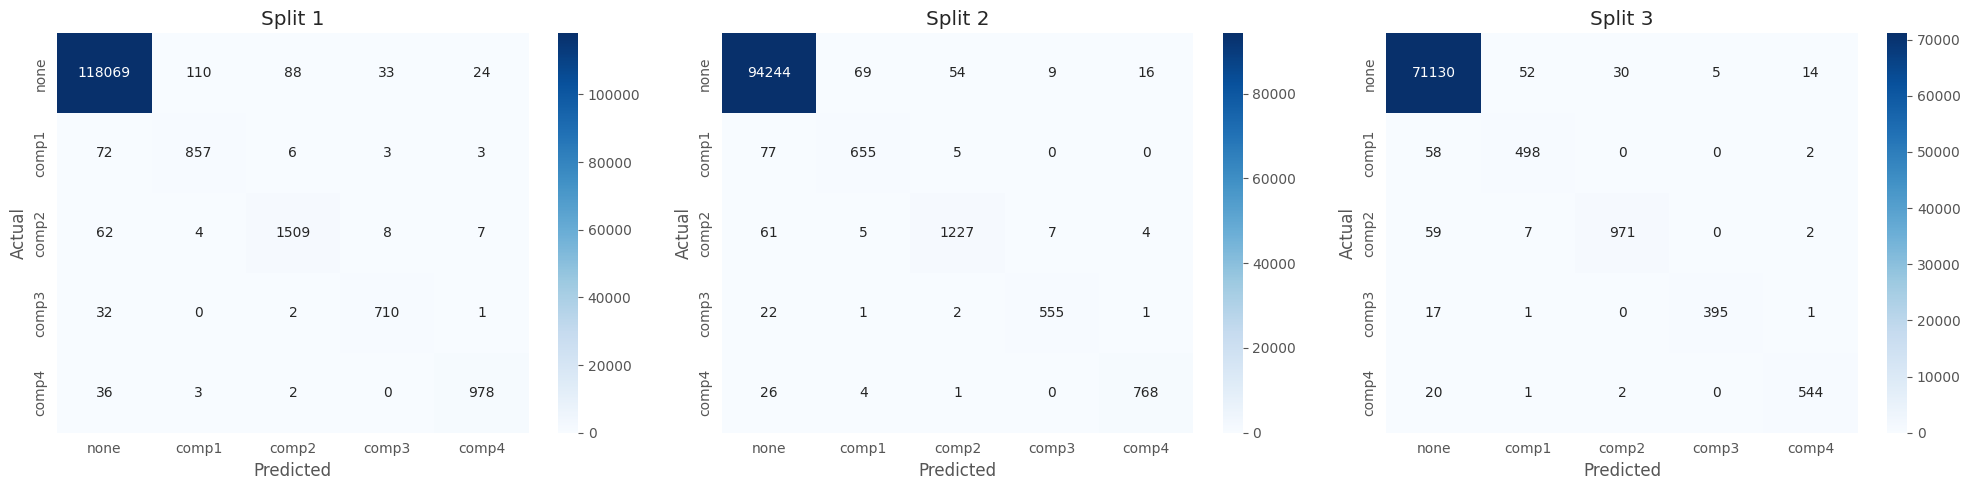

In [ ]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (test_result, ax) in enumerate(zip(test_results, axes)):
    actual = test_result['failure']
    predicted = test_result['predicted_failure']
    cm = confusion_matrix(actual, predicted, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax)
    ax.set_title(f'Split {i+1}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()
